In [1]:
#Import libraries
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, plot_tree
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [2]:
#Load and preprocess data
df = pd.read_csv("dataset/processed/sales_with_products.csv")

<Axes: >

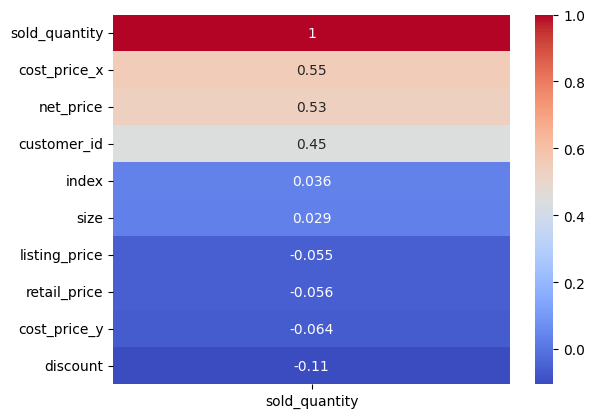

In [3]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr[['sold_quantity']].sort_values(by='sold_quantity', ascending=False), annot=True, cmap="coolwarm")

In [4]:
drop_cols = ['index', 'Start Date', 'color', 'product_id', 'customer_id']
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

In [5]:
df.isna().sum()

distribution_channel_code      0
channel_id                     0
sold_quantity                  0
net_price                      0
cost_price_x                   0
retail_price                   0
cost_price_y                   4
color_group                    1
listing_price                  1
gender                         1
product_group                  1
detail_product_group           1
shoe_product                   1
size_group                     1
size                         178
age_group                      1
activity_group                 1
lifestyle_group                1
launch_season                  1
brand_name                     1
discount                       0
dtype: int64

In [6]:
#Add Unknown for some column like size

for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna("Unknown")
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col] = df[col].fillna(df[col].median())

In [8]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()

In [9]:
df = pd.get_dummies(df, columns=categorical_cols) # switched to one-hot encoding
df.columns = df.columns.str.replace(r"\[|\]|<", "", regex=True)

In [10]:
X = df.drop(columns=['sold_quantity'])
y = df['sold_quantity']

In [11]:
#Define evaluation and logging helper function
def evaluate_model(name, model, X, y, cv):
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)

    mae_scores = -cross_val_score(model, X, y, cv=cv, scoring=make_scorer(mean_absolute_error))
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring="r2")

    return {
        f"{name}_MAE": mae,
        f"{name}_RMSE": rmse,
        f"{name}_R2": r2,
        f"{name}_CV_MAE": mae_scores.mean(),
        f"{name}_CV_R2": r2_scores.mean()
    }

In [ ]:
# Train and log models using K-Fold 
mlflow.set_experiment("sold_quantity_Prediction")
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [13]:
# --- CATBOOST ---
cb_param_grid = {"depth": [6, 8], "learning_rate": [0.1, 0.01], "iterations": [100, 200]}
cb_grid = GridSearchCV(CatBoostRegressor(verbose=0, random_seed=42), param_grid=cb_param_grid,
                      scoring='neg_mean_absolute_error', cv=kf, n_jobs=-1)
cb_grid.fit(X, y)
cb_model = cb_grid.best_estimator_
with mlflow.start_run(run_name="CatBoost_Model"):
    mlflow.log_params({f"catboost_{k}": v for k, v in cb_grid.best_params_.items()})
    metrics = evaluate_model("catboost", cb_model, X, y, kf)
    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(cb_model, "catboost_model")
joblib.dump(cb_model, "model/catboost_model.pkl")

2025/05/30 12:27:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


['model/catboost_model.pkl']

In [ ]:
# --- LIGHTGBM ---
lgb_param_grid = {"num_leaves": [31, 50], "learning_rate": [0.1, 0.01], "n_estimators": [100, 200]}
lgb_grid = GridSearchCV(LGBMRegressor(force_row_wise=True, random_state=42), param_grid=lgb_param_grid,
                       scoring='neg_mean_absolute_error', cv=kf, n_jobs=-1)
lgb_grid.fit(X, y)
lgb_model = lgb_grid.best_estimator_
with mlflow.start_run(run_name="LightGBM_Model"):
    mlflow.log_params({f"lightgbm_{k}": v for k, v in lgb_grid.best_params_.items()})
    metrics = evaluate_model("lightgbm", lgb_model, X, y, kf)
    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(lgb_model, "lightgbm_model")
joblib.dump(lgb_model, "model/lightgbm_model.pkl")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 1746
[LightGBM] [Info] Number of data points in the train set: 466125, number of used features: 144
[LightGBM] [Info] Start training from score 2.507347
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 372900, number of used features: 144
[LightGBM] [Info] Start training from score 2.507485
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 1749
[LightGBM] [Info] Number of data points in the train set: 372900, number of used features: 145
[LightGBM] [Info] Start training from score 2.504827
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 1746
[LightGBM] [Info] Number of data points in the train set: 372900, number of used features: 145
[Ligh

2025/05/30 12:31:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


['lightgbm_model.pkl']

In [15]:
# --- XGBOOST ---
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [2, 3]
}
xgb_grid = GridSearchCV(XGBRegressor(random_state=42, verbosity=0), param_grid=xgb_param_grid,
                       scoring='neg_mean_absolute_error', cv=kf, n_jobs=-1)
xgb_grid.fit(X, y)
xgb_model = xgb_grid.best_estimator_
with mlflow.start_run(run_name="XGBoost_Model"):
    mlflow.log_params({f"xgboost_{k}": v for k, v in xgb_grid.best_params_.items()})
    metrics = evaluate_model("xgboost", xgb_model, X, y, kf)
    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(xgb_model, "xgboost_model")
joblib.dump(xgb_model, "model/xgboost_model.pkl")

2025/05/30 12:39:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


['xgboost_model.pkl']

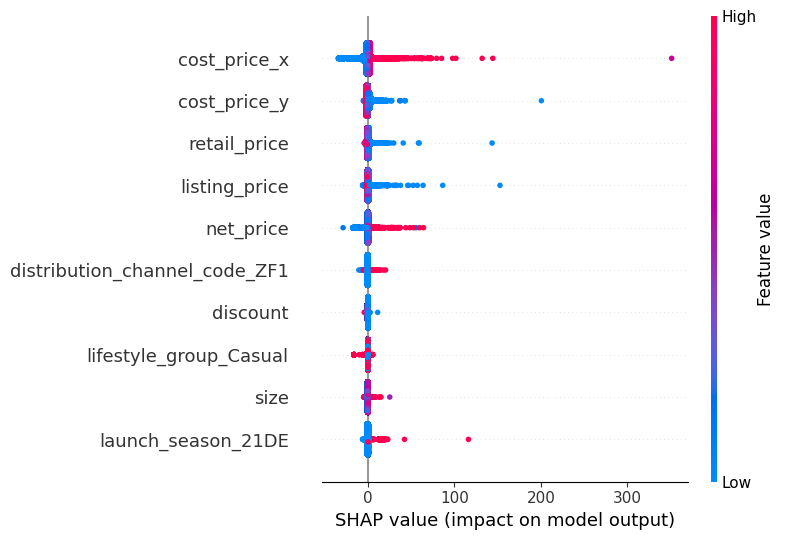

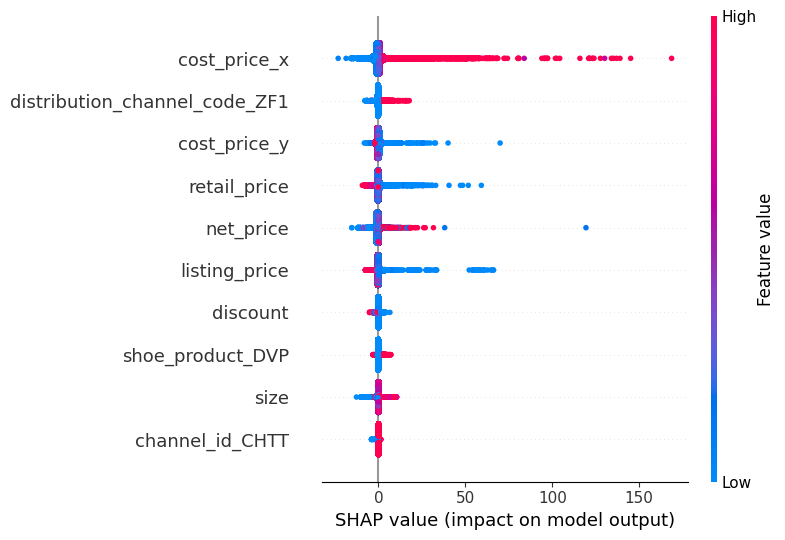

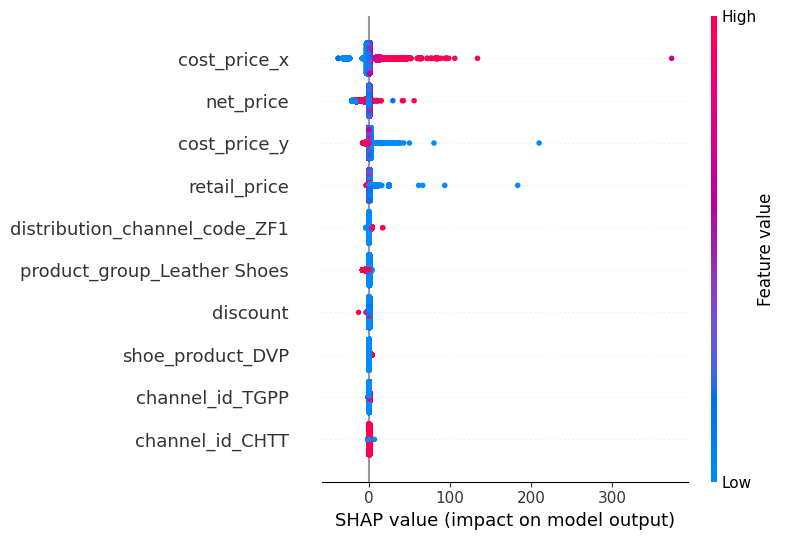

In [16]:
#SHAP Summary Plots 
explainer_cb = shap.Explainer(cb_model); shap.summary_plot(explainer_cb(X), X, max_display=10)
explainer_lgb = shap.Explainer(lgb_model); shap.summary_plot(explainer_lgb(X), X, max_display=10)
explainer_xgb = shap.Explainer(xgb_model); shap.summary_plot(explainer_xgb(X), X, max_display=10)

In [17]:
explainer_cb

In [18]:
explainer_lgb

In [19]:
explainer_xgb

In [ ]:
#First Tree of XGBoost
plt.figure(figsize=(20, 10))
plot_tree(xgb_model, num_trees=0, rankdir='LR')
plt.title("🌳 First tree of the XGBoost model")
plt.show()